In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import Sequential
import numpy as np

In [2]:
DATASET_SINGLE_PATH = './dataset_single.csv'
df = pd.read_csv(DATASET_SINGLE_PATH)
df.head()

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


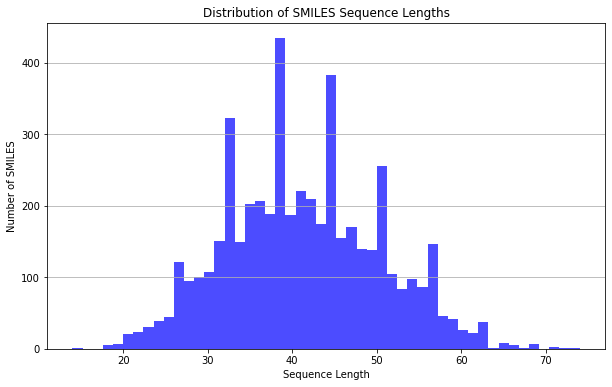

Mean Length: 41.20
Median Length: 41.0
Standard Deviation: 9.14
90th Percentile: 54.0
95th Percentile: 57.0
99th Percentile: 62.0


In [3]:
# Calculate the length of each SMILES string
df['length'] = df['smiles'].apply(len)

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of SMILES Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Number of SMILES')
plt.grid(axis='y')
plt.show()

# Compute and display basic statistics
mean_length = df['length'].mean()
median_length = df['length'].median()
std_dev_length = df['length'].std()
percentile_90 = df['length'].quantile(0.9)
percentile_95 = df['length'].quantile(0.95)
percentile_99 = df['length'].quantile(0.99)

print(f"Mean Length: {mean_length:.2f}")
print(f"Median Length: {median_length}")
print(f"Standard Deviation: {std_dev_length:.2f}")
print(f"90th Percentile: {percentile_90}")
print(f"95th Percentile: {percentile_95}")
print(f"99th Percentile: {percentile_99}")

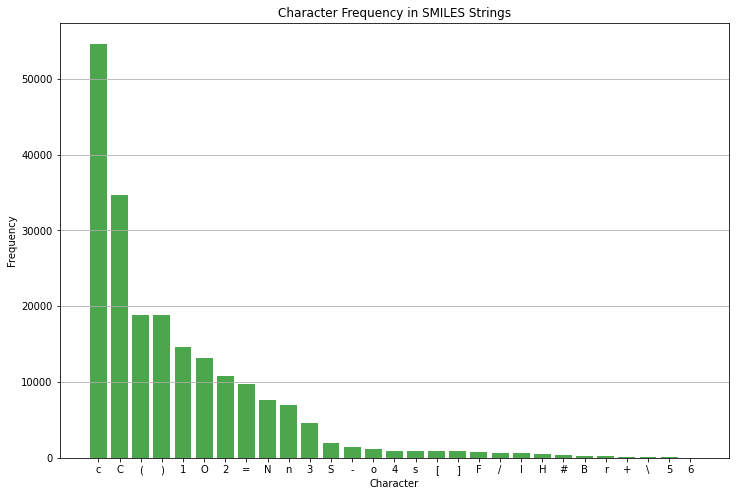

Character: c - Frequency: 54625
Character: C - Frequency: 34625
Character: ( - Frequency: 18769
Character: ) - Frequency: 18769
Character: 1 - Frequency: 14602
Character: O - Frequency: 13148
Character: 2 - Frequency: 10766
Character: = - Frequency: 9707
Character: N - Frequency: 7682
Character: n - Frequency: 7026


In [4]:

# Extract and count all characters from the SMILES strings
all_characters = ''.join(df['smiles'])
char_freq = Counter(all_characters)

# Sort characters by frequency for better visualization
sorted_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)
chars, freqs = zip(*sorted_chars)

# Plot the frequency distribution
plt.figure(figsize=(12, 8))
plt.bar(chars, freqs, color='green', alpha=0.7)
plt.title('Character Frequency in SMILES Strings')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Display top characters and their counts
for char, freq in sorted_chars[:10]:
    print(f"Character: {char} - Frequency: {freq}")


In [5]:
X = df.drop(['P1', 'mol_id'], axis=1)
Y = df['P1']

In [6]:
# Tokenization and padding
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(X['smiles'])
sequences = tokenizer.texts_to_sequences(X['smiles'])
padded_sequences = pad_sequences(sequences, padding='post')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
embedding_dim = 64
vocab_size = len(tokenizer.word_index) + 1

model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=padded_sequences.shape[1]),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Training Model2
model2.fit(X_train, y_train, epochs=100, batch_size=16)
model2.save('./models/model2/model_2.h5/')

# Evaluating Model2
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Model 2 Accuracy: {accuracy*100:.2f}%")

Epoch 1/100
200/200 [==============================] - 20s 16ms/step - loss: 0.4816 - accuracy: 0.8187
Epoch 2/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4699 - accuracy: 0.8224
Epoch 3/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4687 - accuracy: 0.8224
Epoch 4/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4668 - accuracy: 0.8224
Epoch 5/100
200/200 [==============================] - 3s 15ms/step - loss: 0.4664 - accuracy: 0.8224
Epoch 6/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4642 - accuracy: 0.8221
Epoch 7/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4700 - accuracy: 0.8224
Epoch 8/100
200/200 [==============================] - 3s 16ms/step - loss: 0.4657 - accuracy: 0.8224
Epoch 9/100
200/200 [==============================] - 3s 17ms/step - loss: 0.4395 - accuracy: 0.8224
Epoch 10/100
200/200 [==============================] - 3s 17ms/step - loss: 0.43

INFO:tensorflow:Assets written to: ./models/model2/model_2.h5/assets


INFO:tensorflow:Assets written to: ./models/model2/model_2.h5/assets


32/32 [==============================] - 1s 11ms/step - loss: 1.0336 - accuracy: 0.7380
Model 2 Accuracy: 73.80%


In [10]:
# Predicting using Model2
def predict_property_model2(smile):
    sequence = tokenizer.texts_to_sequences([smile])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=padded_sequences.shape[1])
    prediction = model2.predict(padded_sequence)
    return 1 if prediction >= 0.5 else 0

predict_property_model2(X_test[0])

1